### Make sure you've ran the first notebook (zeroest to be more prescise)!

In [1]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pickle

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

cuda = torch.device('cuda')

In [2]:
import ast
# File loading
with open( "../data/ratings_by_user.p", "rb") as f:
    ratings_by_user = pickle.load(f)

with open( "../data/id_to_index.p", "rb") as f:
    id_to_index = pickle.load(f)

movies = torch.load('../data/emb32.pt')

In [3]:
class ML20mDataset(Dataset):
    def __init__(self, files, frame_size, id_to_index):
        self.movies, self.ratings = files
        self.users = list(self.ratings.keys())
        self.user = self.users[0]
        self.frame_size = frame_size
        self.id_to_index = id_to_index
        
    def set_user(self, u):
        # assert u in self.users
        # I commented it out because it seemed to be slowing stuff down
        self.user = u
        
    def __len__(self):
        return len(self.ratings[self.user]) - self.frame_size
    
    def __getitem__(self, idx):
        ratings = self.ratings[self.user][idx:self.frame_size+idx+1]
        chosen_id = ratings['movieId'].values[-1]
        films_index = ratings['movieId'][:-1]
        state = torch.stack([self.movies[self.id_to_index[i]] for i in films_index]).to(cuda)
        next_state = torch.stack([self.movies[self.id_to_index[i]] for i in ratings['movieId'][1:]]).to(cuda)
        action = torch.tensor([self.movies[self.id_to_index[chosen_id]].tolist()]).to(cuda)
        rewards = torch.tensor(ratings['rating'][:self.frame_size].tolist()).to(cuda)
        rewards_next = torch.tensor(ratings['rating'][1:self.frame_size+1].tolist()).to(cuda)
        reward = torch.tensor(ratings['rating'].values[-1]).float().to(cuda)
        done = torch.tensor(idx == self.__len__() - 1).float().to(cuda)
        
        return state, action, rewards, rewards_next, reward, next_state, done
        

In [4]:
dataset = ML20mDataset((movies, ratings_by_user), 10, id_to_index)

### State Representation

In [13]:
class StateRepresentation(nn.Module):
    def __init__(self, frame_size):
        super(StateRepresentation, self).__init__()
        self.frame_size = frame_size
        #self.info_lin = MovieScoreEmbedder().to(cuda)
        self.state_lin = nn.Sequential(
            # 33 = embed_size + rating
            nn.Linear(self.frame_size * 33, 32),
            nn.Tanh()
        ).to(cuda)
        
    def forward(self, info, rewards):
        # info_encoded is f_size x 768
        #info_encoded = self.info_lin(info,rewards)
        
        # Avg Pooling as described in the paper
        #info_encoded = info_encoded.view(1, 1, infonumel())
        #info_encoded = F.avg_pool1d(info_encoded, 2, 2)
        #info_encoded = info_encoded.view(1, info_encoded.numel())
        # 1 x 160
        rewards = torch.unsqueeze(rewards, 2)
        state = torch.cat([info, rewards],2)
        state = state.view(state.size(0), -1)
        state = self.state_lin(state)
        # 1 x 32
        return state

In [14]:
class Actor(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, frame_size, init_w=3e-3):
        super(Actor, self).__init__()
        
        self.frame_size = frame_size
        self.state_rep = StateRepresentation(frame_size)
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, info, rewards):
        state = self.state_rep(info, rewards)
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        return state, x
    
    def get_action(self, info, rewards):
        state, action = self.forward(info, rewards)
        return state, action

In [15]:
import numpy as np
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = 32
        self.low          = -1
        self.high         = 1
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)

In [24]:
class Critic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        action = torch.squeeze(action)
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [49]:
def ddpg_update(batch, 
           gamma = 0.99,
           min_value=0,
           max_value=5,
           soft_tau=1e-2):
    
    state, action, rewards, next_rewards, reward, next_state, done = batch
    
    reward     = reward.unsqueeze(1)
    done       = done.unsqueeze(1)
    
    rep_state, current_action = policy_net(state, rewards)
    
    policy_loss = value_net(rep_state, current_action)
    policy_loss = -policy_loss.mean()

    rep_next_state, next_action = target_policy_net(next_state, next_rewards)
    target_value   = target_value_net(rep_next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(rep_state, action)
    
    value_loss = value_criterion(value, expected_value.detach())

    policy_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward(retain_graph=True)
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )
    return value_loss, policy_loss.item()

In [50]:
ou_noise = OUNoise(32)

value_net  = Critic(32,32,64).to(cuda)
policy_net = Actor(32, 32, 64, 10).to(cuda)

target_value_net  = Critic(32,32,64).to(cuda)
target_policy_net = Actor(32,32, 64, 10).to(cuda)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)
    
    
value_lr  = 1e-3
policy_lr = 1e-4

value_optimizer  = optim.Adam(value_net.parameters(),  lr=value_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)

value_criterion = nn.MSELoss()

In [52]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


def plot(v_loss, p_loss):
    clear_output(True)
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(range(len(v_loss[10:])), v_loss[10:])
    ax1.set_title('Value loss')
    ax2.plot(range(len(p_loss[10:])), p_loss[10:])
    ax2.set_title('Policy loss')
    
v_loss, p_loss = [], []

b_size = 100

def form_batch(batch_list):
    return [torch.stack(i).to(cuda) for i in batch_list]

predicted_corr = []
predicted_t_corr = []
j = None

current_batch = [[] for i in range(7)]
for u in tqdm(dataset.users[:1000]):
    dataset.set_user(u)
    episode_reward = 0
    for b in range(dataset.__len__()):
        minibatch = dataset.__getitem__(b)
        [current_batch[i].append(minibatch[i]) for i in range(7)]
        if len(current_batch[0]) >= b_size:
            current_batch = form_batch(current_batch)
            j = current_batch
            value_loss,policy_loss = ddpg_update(current_batch)
            v_loss.append(value_loss)
            p_loss.append(policy_loss)
            current_batch = [[] for i in range(7)]


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Text(0.5,1,'Policy loss')

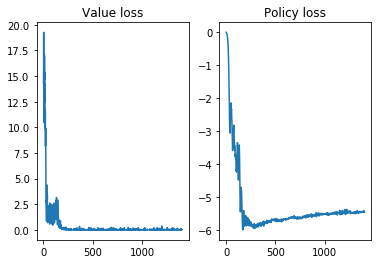

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(len(v_loss)), v_loss)
ax1.set_title('Value loss')
ax2.plot(range(len(p_loss)), p_loss)
ax2.set_title('Policy loss')

Text(0.5,1,'Policy loss')

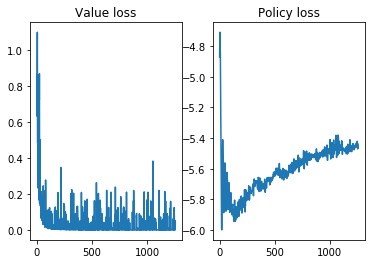

In [55]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(len(v_loss[150:])), v_loss[150:])
ax1.set_title('Value loss')
ax2.plot(range(len(p_loss[150:])), p_loss[150:])
ax2.set_title('Policy loss')

In [12]:
state, action, rewards, next_rewards, reward, next_state, done = j
print(policy_net.state_rep.state_lin[0].weight.data.size())

torch.Size([32, 330])


In [61]:
            current_batch = form_batch(current_batch)
            action = current_batch[1]
            state = current_batch[0]
            rewards = current_batch[2]
            
            predicted = policy_net(state, rewards)
            predicted_t = target_policy_net(state, rewards)
            
            predicted_corr.append(torch.bmm(action, predicted).detach().cpu().numpy().tolist())
            predicted_t.append(torch.bmm(action, predicted).detach().cpu().numpy().tolist())

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor